In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd

from config import Config
from img_util import show_img_tensor_CHW
from img_comment_dataset import ImgCommentDataset
from fliker_data_source import load_fliker_data_items
from pathlib import Path
import torch
from torch.utils.data import DataLoader


/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = Config()
fliker_data_items = load_fliker_data_items(config=config)
print(len(fliker_data_items))

158915


In [3]:
# config = Config()

# img_comments_file = (
#     config.fliker_img_comments_foxlder / "results.csv"
# )  # /Users/chengbai/ml/dataset/flickr30k_images/results.csv
# imgs_folder = (
#     config.fliker_img_comments_folder / "flickr30k_images"
# )  # /Users/chengbai/ml/dataset/flickr30k_images/flickr30k_images

# list(imgs_folder.glob("*.jpg"))[:2]

In [4]:
# # The current `results.csv` file is using "| " to seperate 3 columns.
# # For the pd.read_csv, the `sep` here is given as a regular expression.
# df = pd.read_csv(img_comments_file, sep="|", index_col=False)
# df = df.astype({"image_name": "str", "comment_number": int, "comment": str})
# df1 = df[0:1]
# list(df1["image_name"]), df1["image_name"][0]

In [3]:
train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset = ImgCommentDataset(config, split="test")
print(len(train_dataset), len(eval_dataset), len(test_dataset))

Loaded 158915 fliker image-caption data items.
Loaded 591753 coco image-caption data items.
Loaded 158915 fliker image-caption data items.
Loaded 591753 coco image-caption data items.
Loaded 158915 fliker image-caption data items.
Loaded 591753 coco image-caption data items.
540480 135121 75067


In [4]:
train_dataset.img_comments_df

,image_name,comment_number,comment,image_id
0,/Users/chengbai/ml/dataset/flickr30k_images/fl...,0,Two young guys with shaggy hair look at their ...,0
1,/Users/chengbai/ml/dataset/flickr30k_images/fl...,1,"Two young , White males are outside near many ...",0
2,/Users/chengbai/ml/dataset/flickr30k_images/fl...,2,Two men in green shirts are standing in a yard .,0
3,/Users/chengbai/ml/dataset/flickr30k_images/fl...,3,A man in a blue shirt standing in a garden .,0
4,/Users/chengbai/ml/dataset/flickr30k_images/fl...,4,Two friends enjoy time spent together .,0
...,...,...,...,...
540475,/Users/chengbai/ml/dataset/coco/train2017/0000...,191028,Fruits and vegetables sitting in a bowl on a c...,191028
540476,/Users/chengbai/ml/dataset/coco/train2017/0000...,191042,A few people are playing a game of frisbee.,191042
540477,/Users/chengbai/ml/dataset/coco/train2017/0000...,191047,Two zebras prance through a seemingly abandone...,191047
540478,/Users/chengbai/ml/dataset/coco/train2017/0000...,191054,Three zebras are standing near a lake as they ...,191054


In [5]:
# train_dataset.cache_data()
# eval_dataset.cache_data()
# test_dataset.cache_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5586877..1.8947908].


tokens: 10000
tokenizer.is_fast: True


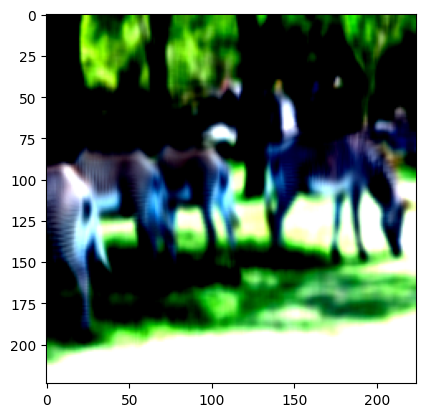

In [6]:
img_aug_tensor1, img_aug_tensor2, img_id_tensor, comment_encoding, comment_mask = (
    train_dataset[-1]
)
show_img_tensor_CHW(img_aug_tensor1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6462783..1.9610363].


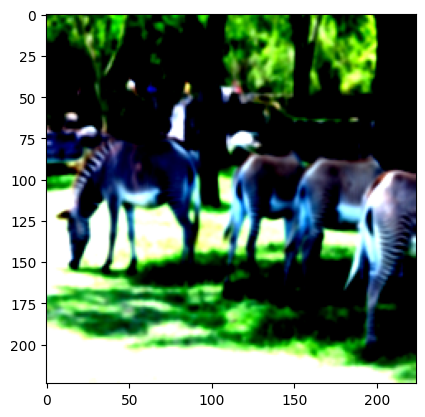

In [7]:
show_img_tensor_CHW(img_aug_tensor2)

In [8]:
# Data Loader
BATCH_SIZE = 2
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# for batch_data in train_dataloader:
#     print(train_dataloader)
#     break
(
    batch_img_aug_tensor1,
    batch_img_aug_tensor2,
    batch_img_id_tensors,
    batch_text_encodings,
    batch_text_masks,
) = next(iter(train_dataloader))
print(f"batch_img_aug_tensor1: {batch_img_aug_tensor1.size()}")
print(f"batch_img_aug_tensor2: {batch_img_aug_tensor2.size()}")
print(f"batch_img_id_tensors: {batch_img_id_tensors.size()}")
print(f"batch_text_encodings: {batch_text_encodings.size()}")
print(f"batch_text_masks: {batch_text_masks.size()}")

batch_img_aug_tensor1: torch.Size([2, 3, 224, 224])
batch_img_aug_tensor2: torch.Size([2, 3, 224, 224])
batch_img_id_tensors: torch.Size([2])
batch_text_encodings: torch.Size([2, 50])
batch_text_masks: torch.Size([2, 50])
